In [1]:
# copyright ############################### #
# This file is part of the Xtrack Package.  #
# Copyright (c) CERN, 2021.                 #
# ######################################### #


import ducktrack as dtk
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider
from tqdm import tqdm

import xtrack as xt
import xobjects as xo
import xpart as xp


beta_rel = 0.305
#beta_rel = 0.106

gamma = 1.050
#gamma = 1.006


current=2.4
length = 1.5 # m cooler length
r_beam=25*1e-3

mass0=938.27208816*1e6 #ev/c^2

T_perp = 100e-3 # <E> [eV] = kb*T
T_l =  1e-3 # <E> [eV]
magnetic_field = 0.060 # T for AD
B_ratio=1e-10



c=299792458.0

p0c = mass0*beta_rel*gamma #eV/c

print(p0c)

circumference = 182.43280000000 #m
T = circumference/(c*beta_rel)
s_per_turn = T


beta_x=10 
beta_y=4

#disp_x=0.12
disp_x=20

arc=xt.LinearTransferMatrix(Q_x=5.44, Q_y=5.42,
                            beta_x_0=beta_x, beta_x_1=beta_x,
                            beta_y_0=beta_y,  beta_y_1=beta_y,
                            alpha_x_0=0,   alpha_x_1=0,
                            alpha_y_0=0,   alpha_y_1=0,
                            disp_x_0=disp_x,disp_x_1=disp_x,
                            disp_y_0=0,    disp_y_1=0,
                            beta_s=1*1e40,
                            Q_s=0,
                            chroma_x=0.0, chroma_y=0)
                                        
offset_x=0
offset_energy=-25

300481636.23323995


In [2]:
#dispersion and space charge parabola

dtk_cooler = dtk.elements.ElectronCooler(current=current,length=length,r_beam=r_beam,
                                         T_perp=T_perp,T_l=T_l,
                                         magnetic_field=magnetic_field,B_ratio=B_ratio,
                                         Neutralisation_space_charge=1,Neutralisation_rotation=0)      


r=np.arange(start=-50*1e-2, stop=50*1e-2, step=1e-3)

#beta_diff=dtk_cooler.radial_velocity_dependence(gamma,r,current,beta_rel,r_beam)   
# beta2=beta_diff+beta_rel

dE_E = (1.2e-4*current/(beta_rel**3))*(r/r_beam)**2


E = dtk_cooler.beta_to_kinetic_energy(beta_rel, dtk_cooler.me_ev)# + Pb_m0_MeV_c2 #Mev/c^2
E_diff = dE_E*E
E_tot = E + E_diff + offset_energy
beta2=dtk_cooler.kinetic_energy_to_beta(E_tot, dtk_cooler.me_ev)
#beta_ratio = beta2/beta
beta_diff = beta2-beta_rel

p0 = beta_rel*dtk_cooler.me_ev*gamma
p2 = beta2*dtk_cooler.me_ev*gamma

dp_p=(p2-p0)/p0                                     



Parameters: $I=2.4 A, B=0.060 T, \beta_x=10 m,\beta_y=4,D_x=0.12 m T_\perp=100meV,T_\parallel=1meV,\epsilon_{x}=35*1e-6,\epsilon_{y}=35*1e-6,dp/p=1e-3$

In [3]:
num_particles=1000
#old
emittance=35*1e-6 #inital emittance
emittance=5*1e-6 #inital emittance

sigma_x = np.sqrt(beta_x*emittance)
sigma_px = np.sqrt(emittance*1/beta_x)
sigma_y = np.sqrt(beta_y*emittance)
sigma_py = np.sqrt(emittance*1/beta_y)
sigma_p = 5e-4



delta = np.random.normal(loc=0.0, scale=sigma_p,  size=num_particles)
x =     np.random.normal(loc=0.0, scale=sigma_x,  size=num_particles)+disp_x*delta
px =    np.random.normal(loc=0.0, scale=sigma_px, size=num_particles)
y =     np.random.normal(loc=0.0, scale=sigma_y,  size=num_particles)
py =    np.random.normal(loc=0.0, scale=sigma_py, size=num_particles)

# #2_sigma
# emittance_x_2sigma=35*1e-6 #inital emittance
# x_2sigma=np.sqrt(beta_x*emittance_x_2sigma)
# x_2sigma_beam=np.random.normal(loc=0.0, scale=x_2sigma,  size=num_particles)

# delta_2sigma=1e-3
# delta_2sigma_beam=np.random.normal(loc=0.0, scale=delta_2sigma,  size=num_particles)

particles = xp.Particles(
        
        mass0=mass0,
        p0c=p0c,
        x=x,
        px=px,
        y=y,
        py=py,
        delta=delta,
        zeta=0)



cooler = xt.ElectronCooler(current=current,length=length,r_beam=r_beam,
                                         T_perp=T_perp,T_l=T_l,
                                         magnetic_field=magnetic_field,B_ratio=B_ratio,
                                         Neutralisation_space_charge=1,
                                         offset_x=offset_x,
                                         offset_energy=offset_energy)

       

num_turns=int(1*1e7)
step=int(num_turns/100)

# initialize arrays
x, px, delta, action_x = [], [], [], []
file_index=0

import shutil
import os

# Change back directory to the old folder
os.chdir('/home/pkruyt/cernbox/electron_cooling/notebooks_xsuite/AD300/video_notebooks')



# os.makedirs("output")  # create a new empty directory
# os.makedirs("output/data")  # create a new empty directory

if not os.path.exists("output"):
    os.makedirs("output")
if not os.path.exists("output/data"):
    os.makedirs("output/data")

# loop over turns
for i in tqdm(range(num_turns)):
    if i % step == 0 or i==0:
        x.append(particles.x)
        px.append(particles.px)
        delta.append(particles.delta)


        # calculate action in horizontal plane
        action_x_temp = (particles.x**2/beta_x + beta_x*particles.px**2)
        action_x.append(action_x_temp)
    
        file_index+=1
        
        np.savez_compressed(f'output/data/data_{file_index}.npz', x=x, px=px, delta=delta, action_x=action_x)
        
        # clear memory
        del x, px, delta, action_x
        x, px, delta, action_x = [], [], [], []

    # track particle
    arc.track(particles)
    cooler.track(particles)
    


#time = np.arange(0, num_turns, step) * s_per_turn   



  0%|          | 0/10000000 [00:00<?, ?it/s]

Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.
Compiling ContextCpu kernels...


  0%|          | 646/10000000 [00:04<11:17:28, 245.99it/s]

Done compiling ContextCpu kernels.


100%|██████████| 10000000/10000000 [35:55<00:00, 4639.55it/s]


100%|██████████| 100/100 [00:52<00:00,  1.92it/s]


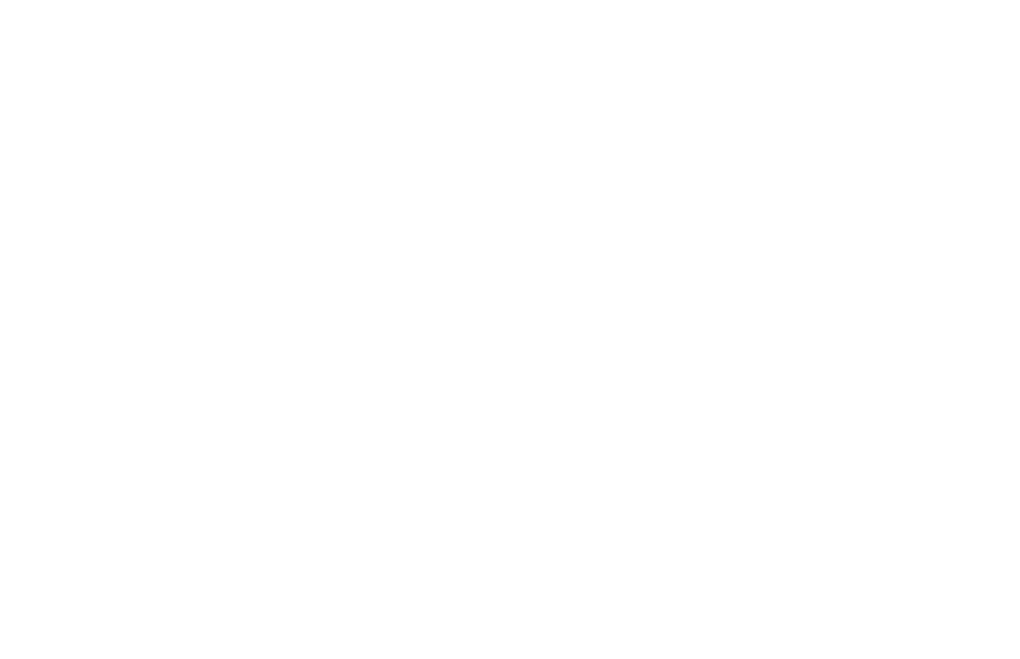

In [4]:
import glob
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import shutil
import os


if not os.path.exists("output/phase_space_plots"):
    os.makedirs("output/phase_space_plots")
    
bins=100
q1_x_list=[]
point_x_list=[]
q3_x_list=[]

q1_delta_list=[]
point_delta_list=[]
q3_delta_list=[]
# loop through all files in output folder
for i, file in enumerate(tqdm(glob.glob('output/data/data_*.npz'))):

    # load data from file
    data = np.load(file)
    x = data['x']
    delta = data['delta']

    x = np.squeeze(x)
    delta = np.squeeze(delta)

    #print(min_distance_x)
    point_x = np.mean(x)
    point_delta = np.mean(delta)

    point_x_list.append(point_x)
    point_delta_list.append(point_delta)

    q1_x = np.percentile(x, 2.5)
    q3_x = np.percentile(x, 97.5)

    q1_delta = np.percentile(delta, 2.5)
    q3_delta = np.percentile(delta, 97.5)

    q1_x_list.append(q1_x)
    q3_x_list.append(q3_x)
    q1_delta_list.append(q1_delta)
    q3_delta_list.append(q3_delta)

    # plot x vs delta
    if i == 0:
        
        fig = plt.figure(figsize=(12, 8), visible=False)
        ax = fig.add_subplot(111)
        ax.scatter(x, delta)
        xlim = ax.get_xlim()
        ylim = ax.get_ylim()

        fig = plt.figure(figsize=(12, 8))
        gs = plt.GridSpec(3, 3, figure=fig)
        ax_main = plt.subplot(gs[1:3, :2])
        ax_xDist = plt.subplot(gs[0, :2], sharex=ax_main)
        ax_yDist = plt.subplot(gs[1:3, 2], sharey=ax_main)

        plt.subplots_adjust(hspace=0.5, wspace=0.5)  # Adjust the spacing here

        ax_main.scatter(x, delta)
        ax_main.plot(r, dp_p, label='space charge electrons', color='red')
        ax_main.plot(r, r * 1 / disp_x, label=f'dispersion = {disp_x}', color='orange')
        ax_main.set_xlabel('x [m]')
        ax_main.set_ylabel('dp/p')
        ax_main.set_title(f'Phase space after {i * step * s_per_turn:.2f} secs')
        ax_main.legend()
        ax_main.set_xlim(xlim)  # Set the x-axis limits
        ax_main.set_ylim(ylim)  # Set the y-axis limits

        ax_xDist.hist(x, bins=bins, align='mid')
        ax_xDist.set(ylabel='count')

        ax_xCumDist = ax_xDist.twinx()
        ax_xCumDist.hist(x, bins=bins, cumulative=True, histtype='step', density=True, color='r', align='mid')
        ax_xCumDist.tick_params('y', colors='r')
        ax_xCumDist.set_ylabel('cumulative', color='r')

        ax_yDist.hist(delta, bins=bins, orientation='horizontal', align='mid')
        ax_yDist.set(xlabel='count')

        ax_yCumDist = ax_yDist.twiny()
        ax_yCumDist.hist(delta, bins=bins, cumulative=True, histtype='step', density=True, color='r',
                         align='mid', orientation='horizontal')
        ax_yCumDist.tick_params('x', colors='r')
        ax_yCumDist.set_xlabel('cumulative', color='r')

        fig.savefig(f'output/phase_space_plots/phase_space_{i:03d}.png', dpi=300)
        plt.close(fig)
        

    else:
        fig = plt.figure(figsize=(12, 8))
        gs = plt.GridSpec(3, 3, figure=fig)
        ax_main = plt.subplot(gs[1:3, :2])
        ax_xDist = plt.subplot(gs[0, :2], sharex=ax_main)
        ax_yDist = plt.subplot(gs[1:3, 2], sharey=ax_main)

        plt.subplots_adjust(hspace=0.5, wspace=0.5)  # Adjust the spacing here

        ax_main.scatter(x, delta)
        ax_main.plot(r, dp_p, label='space charge electrons', color='red')
        ax_main.plot(r, r * 1 / disp_x, label=f'dispersion = {disp_x}', color='orange')
        #ax_main.axhline(0,color='black')
        ax_main.set_xlabel('x [m]')
        ax_main.set_ylabel('dp/p')
        ax_main.set_title(f'Phase space after {i * step * s_per_turn:.2f} secs')
        ax_main.legend()
        ax_main.set_xlim(xlim)  # Set the x-axis limits
        ax_main.set_ylim(ylim)  # Set the y-axis limits

        ax_xDist.hist(x, bins=bins, align='mid')
        ax_xDist.set(ylabel='count')

        ax_xDist.axvline(x=point_x, color='violet', linestyle='--')
        ax_xDist.axvline(x=q1_x, color='yellow', linestyle='--')
        ax_xDist.axvline(x=q3_x, color='yellow', linestyle='--')

        ax_xCumDist = ax_xDist.twinx()
        ax_xCumDist.hist(x, bins=bins, cumulative=True, histtype='step', density=True, color='r', align='mid')
        ax_xCumDist.tick_params('y', colors='r')
        ax_xCumDist.set_ylabel('cumulative', color='r')

        ax_yDist.hist(delta, bins=bins, orientation='horizontal', align='mid')
        ax_yDist.set(xlabel='count')

        ax_yDist.axhline(y=point_delta, color='violet', linestyle='--')
        ax_yDist.axhline(y=q1_delta, color='yellow', linestyle='--')
        ax_yDist.axhline(y=q3_delta, color='yellow', linestyle='--')

        ax_yCumDist = ax_yDist.twiny()
        ax_yCumDist.hist(delta, bins=bins, cumulative=True, histtype='step', density=True, color='r',
                         align='mid', orientation='horizontal')
        ax_yCumDist.tick_params('x', colors='r')
        ax_yCumDist.set_xlabel('cumulative', color='r')

        # save figure
        fig.savefig(f'output/phase_space_plots/phase_space_{i:03d}.png', dpi=300)
        plt.close(fig)


In [5]:
import numpy as np
import os

# Convert the lists to NumPy arrays
q1_x_array = np.array(q1_x_list)
point_x_array = np.array(point_x_list)
q3_x_array = np.array(q3_x_list)

q1_delta_array = np.array(q1_delta_list)
point_delta_array = np.array(point_delta_list)
q3_delta_array = np.array(q3_delta_list)

folder_path = "output/metrics"

if not os.path.exists(folder_path):
    os.makedirs(folder_path)

# Specify the file path where you want to save the data
file_path = 'output/metrics/IQR.npz'

# Save the arrays to disk using numpy's savez function
np.savez(file_path,
         q1_x_list=q1_x_array,
         point_x_list=point_x_array,
         q3_x_list=q3_x_array,
         q1_delta_list=q1_delta_array,
         point_delta_list=point_delta_array,
         q3_delta_list=q3_delta_array)



In [6]:
import os

video_name = f'disp={round(disp_x, 2)},offset_dp={round(offset_energy, 2)},offset_x={round(offset_x, 2)}_IQR'
# Change directory to the desired folder
os.chdir('/home/pkruyt/cernbox/electron_cooling/notebooks_xsuite/AD300/video_notebooks/output/phase_space_plots')
# Run the ffmpeg command
os.system(f'ffmpeg -framerate 10 -pattern_type glob -i "*.png" -c:v libx264 -pix_fmt yuv420p {video_name}.mp4')

import shutil

# Create a new directory 'videos' if it doesn't exist
new_dir = '/home/pkruyt/cernbox/videos'

# Move the video file to the new directory
shutil.move(f'{video_name}.mp4', os.path.join(new_dir, f'{video_name}.mp4'))

# # Change back directory to the old folder
# os.chdir('/home/pkruyt/cernbox/electron_cooling/notebooks_xsuite/AD300')


ffmpeg version 5.1.3 Copyright (c) 2000-2022 the FFmpeg developers
  built with gcc 8 (GCC)
  configuration: --arch=x86_64 --bindir=/usr/bin --datadir=/usr/share/ffmpeg --disable-debug --disable-static --disable-stripping --enable-amf --enable-avcodec --enable-avdevice --enable-avfilter --enable-avformat --enable-alsa --enable-bzlib --enable-chromaprint --enable-decklink --enable-gcrypt --enable-gmp --enable-gpl --enable-gray --enable-iconv --enable-ladspa --enable-libass --enable-libaom --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdc1394 --enable-libdav1d --enable-libdavs2 --enable-libdrm --enable-libfdk-aac --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libiec61883 --enable-libilbc --enable-libjack --enable-libkvazaar --enable-libmodplug --enable-libmp3lame --enable-libndi_newtek --enable-libopencore-amrnb --enable-libopencore-amrwb --enable-libopenh264 --enable-libopenjp

'/home/pkruyt/cernbox/videos/disp=20,offset_dp=-25,offset_x=0_IQR.mp4'